# Predict global forced component from altimetric observations

### Import modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import utils as u
import models as m

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy as cart
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import pyresample
import scipy

u.check_memory()

Using TensorFlow backend.
/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Memory usage: 7.3%


### Load data

In [2]:
obs = xr.open_dataarray('/bettik/lalandmi/github/data/obs_y1993-01-03.5d_sla.nc')
obs

<xarray.DataArray 'sla' (lat: 720, lon: 1440)>
[1036800 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
    time     datetime64[ns] ...
Attributes:
    units:      m
    long_name:  Sea level anomalies

<IPython.core.display.Javascript object>


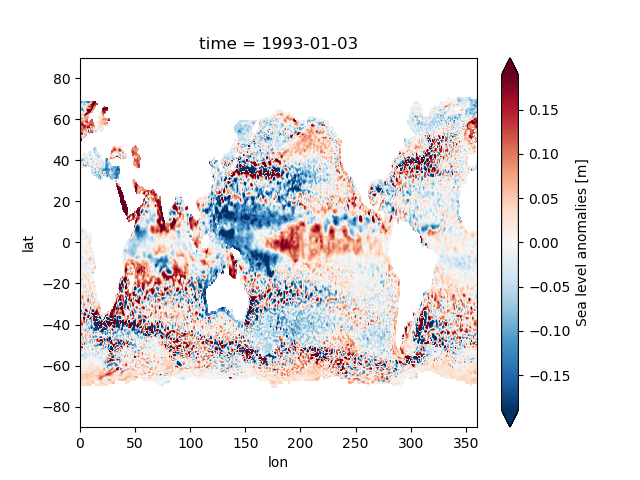

In [3]:
plt.figure()
obs.plot(robust=True)

### Regrid data on the model grid for applying the U-Net algorithm

It is possible to directly apply the U-Net on the observation grid if they are at the same resolution 1/4°; however, results should be more accurate when applied on the model grid on which the algorithm has learned, even if the consecutive regrid introduce some errors too. We use here the Inverse Weight Distance (IWD) for regriding from the regular observation grid to the curvilinear model's grid with Pyresample (http://earthpy.org/interpolation_between_grids_with_pyresample.html). Any other interpolation method can be used.

In [4]:
model_grid_data = xr.open_dataarray('data/ORCA025.L75-OCCITENS.e001_y1979-01-03.5d_sla.nc')

# load lat-lon of the target grid
lon_curv = model_grid_data.nav_lon.values
lat_curv = model_grid_data.nav_lat.values

# load lat-lon-value of the origin data
lat = obs.lat.values
lon = obs.lon.values

# Pyresample only deal with data between -180/180 in longitude, thus the -180 bellow. 
# It leads to wrong longitude on the model grid, however, after reinterpolation on the observation grid it works. 
# Otherwise you have to shift also the data before regrid. 
lon2d, lat2d = np.meshgrid(lon - 180, lat) 


orig_def = pyresample.geometry.SwathDefinition(lons=lon2d, lats=lat2d)
targ_def = pyresample.geometry.SwathDefinition(lons=lon_curv, lats=lat_curv)

# Make Inverse Weight Dsitance interpolation
# We interpolate the observation in order not to have too much impact from lands (optional)
obs_regrid_iwd = model_grid_data.copy()
wf = lambda r: 1/r**2
obs_regrid_iwd.values = pyresample.kd_tree.resample_custom(
    orig_def, obs.interpolate_na(dim='lon').values, targ_def, 
    radius_of_influence=500000, neighbours=10, weight_funcs=wf, fill_value=None
)

/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/pyresample/kd_tree.py:387: UserWarning: Possible more than 10 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))


<IPython.core.display.Javascript object>


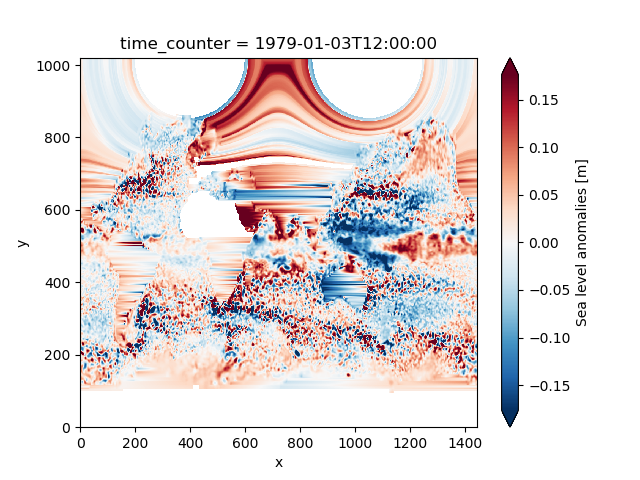

In [5]:
plt.figure()
obs_regrid_iwd.plot(robust=True)

The regrid worked. Be aware the longitudes are not right as mentioned in the cell above. The interpolation of Nan values is not necessary and can be performed in a better way, but it allows not to have too much extent of lands after the IWD regrid (it is not perfect, and it will be applied back before applying the U-Net algorithm). By the way, we do not have a full mask on the model grid (for lands ok but we do not have the ice mask), this is only a temporary result for applying the U-Net algorithm before regriding back to the observation grid.

### Apply the U-Net
We are going to replicate the image from few pixels on left and right side of the image to avoid a break in longitude (the convolution kernel of the U-Net is 3x3 pixels and 2 downscalling are applied so we are using here 12 pixels each side but it is not perfect solution). Fell free to improve this.

In [6]:
nx = obs_regrid_iwd.x.size
ny = obs_regrid_iwd.y.size
d = 12 # Number of pixels to replicate left and right of the image

In [7]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

model = m.unet((ny, nx+(2*d), 1))
model.load_weights('model_weights/weights-unet_2s_32f-zone123.h5')
model.summary()
model.name

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1021, 1466, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1021, 1466, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1021, 1466, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 510, 733, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

'unet_2s_32f'

In [8]:
obs_regrid_iwd = obs_regrid_iwd.interpolate_na(dim='x').fillna(0)
obs_regrid_iwd_forced = obs_regrid_iwd.copy()

# We replicate some pixels in both sides in longitude in order to have a continuity
obs_tmp = np.zeros((ny, nx+(2*d)))
pred_tmp = np.zeros((ny, nx+(2*d)))

obs_tmp[:,0:12] = obs_regrid_iwd[:,1442-12:].values
obs_tmp[:,12:1442+12] = obs_regrid_iwd[:,:].values
obs_tmp[:,1442+12:] = obs_regrid_iwd[:,0:12].values

# Make the global prediction of the forced component
pred_tmp = model.predict(obs_tmp.reshape(1, ny, nx+(2*d), 1)).reshape(ny, nx+(2*d))

# Apply Gaussian filter (no need of mask here because no mask is set)
pred_tmp = scipy.ndimage.filters.gaussian_filter(pred_tmp, sigma=0.7)

# Come back to initial size
obs_regrid_iwd_forced.values = pred_tmp[:,12:1442+12]

<IPython.core.display.Javascript object>


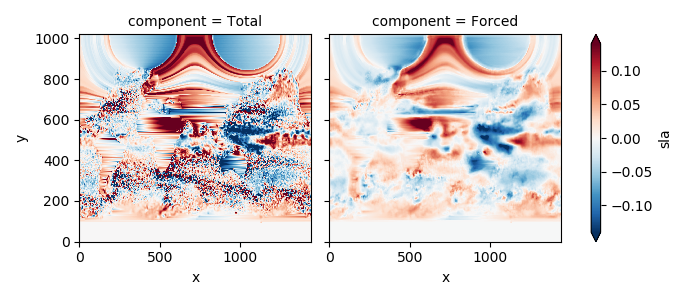

In [9]:
concat = xr.concat([obs_regrid_iwd, obs_regrid_iwd_forced], pd.Index(['Total', 'Forced'], name='component'))
concat.plot(robust=True, col='component', col_wrap=2)

### Regrid back to observation grid

In [10]:
obs_forced = obs.copy()
mask = obs*0

obs_forced.values = pyresample.kd_tree.resample_custom(
    targ_def, obs_regrid_iwd_forced.values, orig_def, 
    radius_of_influence=500000, neighbours=10, weight_funcs=wf, fill_value=None
) + mask

/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/pyresample/kd_tree.py:387: UserWarning: Possible more than 10 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))


<IPython.core.display.Javascript object>


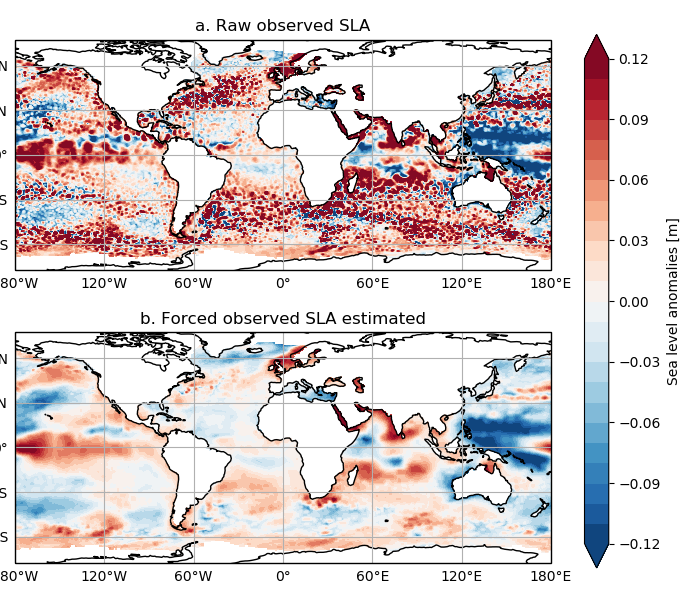

In [11]:
concat = xr.concat([obs, obs_forced], pd.Index(['Total', 'Forced'], name='component'))

map_proj = ccrs.PlateCarree(central_longitude=0)

p = concat.plot.contourf(
    transform=ccrs.PlateCarree(),  
    col='component', col_wrap=1,  
    aspect=concat.lon.shape[0] / concat.lat.shape[0],  
    subplot_kws={'projection': map_proj}, levels=np.arange(-0.12,0.13,0.01), zorder=-1,
    cbar_kwargs={'label': 'Sea level anomalies [m]'}
) 

titles = ['a. Raw observed SLA', 'b. Forced observed SLA estimated']


for i, ax in enumerate(p.axes.flat):
    ax.coastlines()
    ax.set_aspect('equal')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180+60,60))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,90+30,30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.set_title(titles[i])
    ax.set_rasterization_zorder(0)

plt.savefig('img/obs_forced.pdf', bbox_inches='tight', dpi=300)
plt.savefig('img/obs_forced.png', bbox_inches='tight', dpi=300)

plt.show()